# Price-Momentum

In [ ]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import numpy as np
from bs4 import BeautifulSoup
import requests

list_ticker = [
    "AI.PA",
    "AIR.PA",
    # "ALO.PA",
    # "MT.AS",
    # "CS.PA",
    # "BNP.PA",
    # "EN.PA",
    # "CAP.PA",
    # "CA.PA",
    # "ACA.PA",
    # "BN.PA",
    # "DSY.PA",
    # "EDEN.PA",
    # "ENGI.PA",
    # "EL.PA",
    # "ERF.PA",
    # "RMS.PA",
    # "KER.PA",
    # "LR.PA",
    # "OR.PA",
    # "MC.PA",
    # "ML.PA",
    # "ORA.PA",
    # "RI.PA",
    # "PUB.PA",
    # "RNO.PA",
    # "SAF.PA",
    # "SGO.PA",
    # "SAN.PA",
    # "SU.PA",
    # "GLE.PA",
    # "STLAP.PA",
    "STMPA.PA",
    # "TEP.PA",
    # "HO.PA",
    # "TTE.PA",
    # "URW.PA",
    # "VIE.PA",
    # "DG.PA",
    # "VIV.PA"
]

# Function to calculate momentum (Si,t-Si,t-h)/(Si,t-h) return during h lookback period
def calculate_momentum(prices, lookback_period):
    momentum = prices.pct_change(lookback_period)
    return momentum

# Constants
LOOKBACK_PERIOD = 63  # Approximately 3 months of trading days
REBALANCE_FREQ = '1D'  # Daily rebalancing
INVESTMENT_AMOUNT = 100000  # Amount invested each time
RISK_FREE_RATE = 0.01  # Assumed risk-free rate for Sharpe ratio calculation

def momentum_strategy(ticker, start_date, end_date):
    # Download data and convert into dataframe
    data = yf.download(ticker, start=start_date, end=end_date)['Close'].to_frame(name=ticker)

    # Momentum calculation
    momentum_scores = calculate_momentum(data, LOOKBACK_PERIOD)

    # Initialization of long and short signals
    long_signals = pd.Series(False, index=data.index)
    short_signals = pd.Series(False, index=data.index)

    for date in momentum_scores.index:
        today_momentum = momentum_scores.at[date, ticker]
        if today_momentum > 0:
            long_signals.at[date] = True
        elif today_momentum <= 0:
            short_signals.at[date] = True

    return long_signals, short_signals, data

def rank_asset(ticker, long_signals, short_signals, start_date, end_date):
    # Count the number of long and short signals within the period
    nb_long_signals = long_signals.loc[start_date:end_date].sum()
    nb_short_signals = short_signals.loc[start_date:end_date].sum()

    # Avoid division by zero
    if nb_short_signals == 0:
        ratio = float('inf')  # Assign infinity if no short signals
    else:
        ratio = nb_long_signals / nb_short_signals

    return ratio

def calculate_performance_metrics(ticker, returns, risk_free_rate):
    annualized_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)
    return annualized_volatility, sharpe_ratio

def execution_momentum_strategy(ticker, start_date, end_date):
    long_signals, short_signals, data = momentum_strategy(ticker, start_date, end_date)
    in_position = False
    entry_price = 0
    total_return = 0
    entry_date = []
    exit_date = []
    position_sizes = []
    daily_returns = []

    # Adjust end_date to the closest available date in data if it's not present
    end_date = pd.to_datetime(end_date)
    if end_date not in data.index:
        end_date = data.index[data.index < end_date][-1]

    for date in data.index:
        if not in_position and long_signals[date]:
            entry_price = data.at[date, ticker]
            position_size = INVESTMENT_AMOUNT / entry_price
            position_sizes.append(position_size)
            entry_date.append(date)
            in_position = True
        elif in_position and (short_signals[date] or date == end_date):
            exit_price = data.at[date, ticker]
            total_return += (exit_price - entry_price) * position_sizes[-1]
            exit_date.append(date)
            daily_returns.append((exit_price - entry_price) / entry_price)
            in_position = False

    total_return_percent = (total_return / INVESTMENT_AMOUNT) * 100 if position_sizes else 0

    # Calculate performance metrics
    daily_returns = pd.Series(daily_returns)
    annualized_volatility, sharpe_ratio = calculate_performance_metrics(ticker, daily_returns, RISK_FREE_RATE)

    return total_return_percent, entry_date, exit_date, annualized_volatility, sharpe_ratio

def momentum_strategy_trading_final(tickers, start_date, end_date):
    results = []

    for ticker in tickers:
        total_return, entry_date, exit_date, annualized_volatility, sharpe_ratio = execution_momentum_strategy(ticker, start_date, end_date)
        print(f"Total Return Rate for {ticker}: {total_return:.2f} %")
        print(f"Entry Dates for {ticker}: {entry_date}")
        print(f"Exit Dates for {ticker}: {exit_date}")
        print(f"Annualized Volatility for {ticker}: {annualized_volatility:.2f}")
        print(f"Sharpe Ratio for {ticker}: {sharpe_ratio:.2f}")

        # Collect results for the table
        results.append({
            'Ticker': ticker,
            'Total Return (%)': total_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio
        })

        # Filter data for long and short signals for plotting
        long_signals, short_signals, data = momentum_strategy(ticker, start_date, end_date)
        long_data = data[long_signals]
        short_data = data[short_signals]

        # Dynamic plot using Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data.index, y=data[ticker], mode='lines', name=f'{ticker} Price'))
        fig.add_trace(go.Scatter(x=long_data.index, y=long_data[ticker], mode='markers', name='Long Signal', marker=dict(color='green', size=10, symbol='triangle-up')))
        fig.add_trace(go.Scatter(x=short_data.index, y=short_data[ticker], mode='markers', name='Short Signal', marker=dict(color='red', size=10, symbol='triangle-down')))
        fig.update_layout(title=f'{ticker} Momentum Trading Signals', xaxis_title='Date', yaxis_title='Price')
        fig.show()

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results)
    print("\nPerformance Metrics:")
    print(results_df)

momentum_strategy_trading_final(list_ticker, '2023-01-01', '2024-06-01')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Total Return Rate for AI.PA: 11.27 %
Entry Dates for AI.PA: [Timestamp('2023-03-30 00:00:00'), Timestamp('2023-07-12 00:00:00'), Timestamp('2023-07-28 00:00:00'), Timestamp('2023-08-10 00:00:00'), Timestamp('2023-08-18 00:00:00'), Timestamp('2023-09-14 00:00:00'), Timestamp('2023-10-03 00:00:00'), Timestamp('2023-10-10 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-08 00:00:00')]
Exit Dates for AI.PA: [Timestamp('2023-07-06 00:00:00'), Timestamp('2023-07-17 00:00:00'), Timestamp('2023-08-01 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-22 00:00:00'), Timestamp('2023-10-09 00:00:00'), Timestamp('2023-10-17 00:00:00'), Timestamp('2023-11-07 00:00:00'), Timestamp('2024-05-22 00:00:00')]
Annualized Volatility for AI.PA: 0.62
Sharpe Ratio for AI.PA: 0.52


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Total Return Rate for AIR.PA: 19.54 %
Entry Dates for AIR.PA: [Timestamp('2023-03-30 00:00:00'), Timestamp('2023-06-01 00:00:00'), Timestamp('2023-08-18 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-11-13 00:00:00'), Timestamp('2023-11-29 00:00:00')]
Exit Dates for AIR.PA: [Timestamp('2023-05-31 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2023-09-13 00:00:00'), Timestamp('2023-09-21 00:00:00'), Timestamp('2023-11-27 00:00:00'), Timestamp('2024-05-31 00:00:00')]
Annualized Volatility for AIR.PA: 0.90
Sharpe Ratio for AIR.PA: 6.30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Total Return Rate for STMPA.PA: -37.23 %
Entry Dates for STMPA.PA: [Timestamp('2023-03-30 00:00:00'), Timestamp('2023-06-13 00:00:00'), Timestamp('2023-07-12 00:00:00'), Timestamp('2023-11-15 00:00:00'), Timestamp('2023-12-01 00:00:00'), Timestamp('2024-01-18 00:00:00'), Timestamp('2024-02-16 00:00:00'), Timestamp('2024-02-22 00:00:00'), Timestamp('2024-02-27 00:00:00')]
Exit Dates for STMPA.PA: [Timestamp('2023-04-27 00:00:00'), Timestamp('2023-06-19 00:00:00'), Timestamp('2023-09-05 00:00:00'), Timestamp('2023-11-16 00:00:00'), Timestamp('2024-01-08 00:00:00'), Timestamp('2024-02-15 00:00:00'), Timestamp('2024-02-19 00:00:00'), Timestamp('2024-02-23 00:00:00'), Timestamp('2024-02-28 00:00:00')]
Annualized Volatility for STMPA.PA: 1.03
Sharpe Ratio for STMPA.PA: -12.53



Performance Metrics:
     Ticker  Total Return (%)  Annualized Volatility  Sharpe Ratio
0     AI.PA         11.269180               0.620962      0.515061
1    AIR.PA         19.544480               0.902870      6.300662
2  STMPA.PA        -37.225402               1.033284    -12.526188


# Earning-Momentum

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta


ftse100=pd.read_html('https://en.wikipedia.org/wiki/FTSE_100_Index')[4]
tickers=list(ftse100.Ticker.unique())
tickers = [ticker + "L" if '.' in ticker else ticker + ".L" for ticker in tickers]
data_close = yf.download(tickers, start='2010-01-01', end='2024-01-01')['Adj Close']
data_close = data_close.dropna(how='any')
# Fonction pour obtenir la capitalisation boursière et le prix
def get_market_cap(ticker, date):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=date, end=date + timedelta(days=1))
    if hist.empty:
        print(f"Aucune donnée disponible pour la date {date.strftime('%Y-%m-%d')}.")
        return None, None
    price = hist['Close'].iloc[0]
    info = stock.info
    shares_outstanding = info.get('sharesOutstanding', 0)
    market_cap = price * shares_outstanding
    return market_cap

def get_market_price(ticker, date):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=date, end=date + timedelta(days=1))
    if hist.empty:
        print(f"Aucune donnée disponible pour la date {date.strftime('%Y-%m-%d')}.")
        return None
    price = hist['Close'].iloc[0]
    return price

# Fonction pour calculer la pondération
def calculate_ponderation(date, tickers):
    market_cap = []
    prices = []
    for ticker in tickers:
        market_cap_ticker = get_market_cap(ticker, date)
        price_ticker = get_market_price(ticker, date)
        if market_cap_ticker is not None and price_ticker is not None:
            market_cap.append(market_cap_ticker)
            prices.append(price_ticker)
    total_market_cap = sum(market_cap)
    ponderation = [mc / total_market_cap for mc in market_cap]
    return ponderation

def calculate_index_value(ponderation, prices):
    somme_ponde = sum(ponderation[i] * prices[i] for i in range(len(ponderation)))
    return somme_ponde

# Initialiser les variables
dates = []
start_date = data_close.index[0]
end_date = data_close.index[-1]
low_vol_index = []
high_vol_index = []
# low_cap_index = []
# high_cap_index = []
current_date = start_date
dates.append(start_date)
divisor = 0.3877505767798659  # Initial divisor

# Download the initial price of the FTSE index
ftse_index = yf.download('^FTSE', start=start_date, end=end_date + timedelta(days=1))['Adj Close']
ftse_index = ftse_index[ftse_index.index.isin(data_close.index)]
initial_ftse_price = ftse_index[0]
low_vol_index.append(initial_ftse_price)
high_vol_index.append(initial_ftse_price)
# low_cap_index.append(initial_ftse_price)
# high_cap_index.append(initial_ftse_price)

# Loop over dates
while current_date <= end_date:

    next_date = current_date + relativedelta(months=3)
    if next_date > end_date + timedelta(days=1) :
        break

    # Select data for the current period
    monthly_data = data_close.loc[current_date:next_date]

    # Calculer les rendements mensuels et la volatilité
    monthly_returns = monthly_data.pct_change().dropna()
    monthly_volatility = monthly_returns.std() * np.sqrt(252)

    # Classer et sélectionner les actions à faible et haute volatilité
    low_volatility_stocks = monthly_volatility.nsmallest(25)
    high_volatility_stocks = monthly_volatility.nlargest(25)

    # Allouer les poids inversément proportionnels à la volatilité
    low_vol_weights = 1 / low_volatility_stocks
    low_vol_weights /= low_vol_weights.sum()
    high_vol_weights = 1 / high_volatility_stocks
    high_vol_weights /= high_vol_weights.sum()

    tickers_low_volatility = list(low_volatility_stocks.index)
    tickers_high_volatility = list(high_volatility_stocks.index)

    # low_cap_weights = calculate_ponderation(current_date, tickers_low_volatility)
    # high_cap_weights = calculate_ponderation(current_date, tickers_high_volatility)

    # Utiliser les dates du FTSE 100 pour les pondérations
    ftse_dates = ftse_index.loc[current_date:next_date].index

    for i, date in enumerate(ftse_dates):
        low_vol_prices = data_close.loc[date, tickers_low_volatility]
        high_vol_prices = data_close.loc[date, tickers_high_volatility]

        # # Calculer la valeur de l'index basé sur le calcul du FTSE100 (market_cap)
        # index_value_cap_low_vol = calculate_index_value(low_cap_weights, low_vol_prices.tolist())
        # index_value_cap_high_vol = calculate_index_value(high_cap_weights, high_vol_prices.tolist())

        # Calculer la valeur de l'index basé sur la proportion inverse de la volatilité
        index_value_low_vol = calculate_index_value(low_vol_weights, low_vol_prices.tolist())
        index_value_high_vol = calculate_index_value(high_vol_weights, high_vol_prices.tolist())

        # Calculer les indices des portefeuilles
        if i == 0:  # Ajuster le divisor au début de la nouvelle période
            # divisor_cap_low_vol = index_value_cap_low_vol / low_cap_index[-1]
            # divisor_cap_high_vol = index_value_cap_high_vol / high_cap_index[-1]
            divisor_low_vol = index_value_low_vol / low_vol_index[-1]
            divisor_high_vol = index_value_high_vol / high_vol_index[-1]

        # index_value_cap_low_vol /= divisor_cap_low_vol
        # index_value_cap_high_vol /= divisor_cap_high_vol
        index_value_low_vol /= divisor_low_vol
        index_value_high_vol /= divisor_high_vol

        # Stocker les résultats
        dates.append(date)
        # low_cap_index.append(index_value_cap_low_vol)
        # high_cap_index.append(index_value_cap_high_vol)
        low_vol_index.append(index_value_low_vol)
        high_vol_index.append(index_value_high_vol)

    current_date = next_date


# Créer des séries temporelles pour les indices
# low_cap_index_series = pd.Series(low_cap_index, index=dates)
# high_cap_index_series = pd.Series(high_cap_index, index=dates)
low_vol_index_series = pd.Series(low_vol_index, index=dates)
high_vol_index_series = pd.Series(high_vol_index, index=dates)

shortest_end_date = min(low_vol_index_series.index[-1], ftse_index.index[-1])

# Truncate all series to the shortest end date
low_vol_index_series = low_vol_index_series.loc[:shortest_end_date]
high_vol_index_series = high_vol_index_series.loc[:shortest_end_date]
# low_cap_index_series = low_cap_index_series.loc[:shortest_end_date]
# high_cap_index_series = high_cap_index_series.loc[:shortest_end_date]
ftse_index = ftse_index.loc[:shortest_end_date]

# Tracer les indices avec Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=low_vol_index_series.index, y=low_vol_index_series, mode='lines', name='Low Volatility Index with Inversely Proportional Weighting'))
fig.add_trace(go.Scatter(x=high_vol_index_series.index, y=high_vol_index_series, mode='lines', name='High Volatility Index with Inversely Proportional Weighting'))
fig.add_trace(go.Scatter(x=ftse_index.index, y=ftse_index, mode='lines', name='FTSE100 Index'))
fig.show()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=low_cap_index_series.index, y=low_cap_index_series, mode='lines', name='Low Volatility Index with Market Cap ponderation Weighting'))
# fig.add_trace(go.Scatter(x=high_cap_index_series.index, y=high_cap_index_series, mode='lines', name='High Volatility Index with Market Cap ponderation Weighting'))
# fig.add_trace(go.Scatter(x=ftse_index.index, y=ftse_index, mode='lines', name='FTSE100 Index'))
# fig.show()

# Calculate daily returns
low_vol_returns = low_vol_index_series.pct_change().dropna()
high_vol_returns = high_vol_index_series.pct_change().dropna()
# low_cap_returns = low_cap_index_series.pct_change().dropna()
# high_cap_returns = high_cap_index_series.pct_change().dropna()
ftse_returns = ftse_index.pct_change().dropna()

fig = go.Figure()

fig.add_trace(go.Scatter(x=low_vol_returns.index, y=low_vol_returns, mode='lines', name='Low Volatility Index with Inversely Proportional Weighting'))
fig.add_trace(go.Scatter(x=high_vol_returns.index, y=high_vol_returns, mode='lines', name='High Volatility Index with Inversely Proportional Weighting'))
fig.add_trace(go.Scatter(x=ftse_returns.index, y=ftse_returns, mode='lines', name='FTSE100 Index'))

fig.show()

# fig = go.Figure()

# fig.add_trace(go.Scatter(x=low_cap_returns.index, y=low_cap_returns, mode='lines', name='Low Volatility Index with Market Cap ponderation Weighting'))
# fig.add_trace(go.Scatter(x=high_cap_returns.index, y=high_cap_returns, mode='lines', name='High Volatility Index with Market Cap ponderation Weighting'))
# fig.add_trace(go.Scatter(x=ftse_returns.index, y=ftse_returns, mode='lines', name='FTSE100 Index'))

# fig.show()

low_vol_returns = low_vol_returns[~low_vol_returns.index.duplicated(keep='first')]
high_vol_returns = high_vol_returns[~high_vol_returns.index.duplicated(keep='first')]
ftse_returns = ftse_returns[~ftse_returns.index.duplicated(keep='first')]

aligned_returns = pd.concat([low_vol_returns, high_vol_returns, ftse_returns], axis=1, join='inner')
aligned_returns.columns = ['low_vol', 'high_vol', 'ftse']

# Extract aligned returns
low_vol_returns_aligned = aligned_returns['low_vol']
high_vol_returns_aligned = aligned_returns['high_vol']
ftse_returns_aligned = aligned_returns['ftse']

# Function to calculate alpha and beta
def calculate_alpha_beta(returns, benchmark_returns):
    cov_matrix = np.cov(returns, benchmark_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    alpha = returns.mean() - beta * benchmark_returns.mean()
    return alpha*10000, beta

# Calculate Alpha and Beta for each portfolio
alpha_low_vol, beta_low_vol = calculate_alpha_beta(low_vol_returns_aligned, ftse_returns_aligned)
alpha_high_vol, beta_high_vol = calculate_alpha_beta(high_vol_returns_aligned, ftse_returns_aligned)
alpha_ftse, beta_ftse = 0, 1  # By definition, the benchmark itself has alpha=0 and beta=1

# Function to calculate upside and downside capture ratios
def calculate_capture_ratios(portfolio_returns, benchmark_returns):
    aligned = pd.concat([portfolio_returns, benchmark_returns], axis=1, join='inner')
    aligned.columns = ['portfolio', 'benchmark']

    upside_capture = aligned[aligned['benchmark'] > 0]['portfolio'].mean() / aligned[aligned['benchmark'] > 0]['benchmark'].mean()
    downside_capture = aligned[aligned['benchmark'] < 0]['portfolio'].mean() / aligned[aligned['benchmark'] < 0]['benchmark'].mean()

    return upside_capture, downside_capture

# Calculate capture ratios for each portfolio
upside_capture_low_vol, downside_capture_low_vol = calculate_capture_ratios(low_vol_returns_aligned, ftse_returns_aligned)
upside_capture_high_vol, downside_capture_high_vol = calculate_capture_ratios(high_vol_returns_aligned, ftse_returns_aligned)
upside_capture_ftse, downside_capture_ftse = 1, 1  # By definition, the benchmark itself has ratios of 1

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# Calculate Sharpe ratio for each portfolio
risk_free_rate = 0.01  # Assuming a 1% annual risk-free rate
sharpe_ratio_low_vol = calculate_sharpe_ratio(low_vol_returns_aligned, risk_free_rate)
sharpe_ratio_high_vol = calculate_sharpe_ratio(high_vol_returns_aligned, risk_free_rate)
sharpe_ratio_ftse = calculate_sharpe_ratio(ftse_returns_aligned, risk_free_rate)

# Function to calculate Sortino ratio
def calculate_sortino_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std() * np.sqrt(252)

# Calculate Sortino ratio for each portfolio
sortino_ratio_low_vol = calculate_sortino_ratio(low_vol_returns_aligned, risk_free_rate)
sortino_ratio_high_vol = calculate_sortino_ratio(high_vol_returns_aligned, risk_free_rate)
sortino_ratio_ftse = calculate_sortino_ratio(ftse_returns_aligned, risk_free_rate)

# Function to calculate annualized return
def calculate_annualized_return(returns):
    compounded_growth = (1 + returns).prod()
    n_periods = returns.shape[0]
    return (compounded_growth ** (252 / n_periods) - 1)*100

# Calculate annualized return for each portfolio
annualized_return_low_vol = calculate_annualized_return(low_vol_returns_aligned)
annualized_return_high_vol = calculate_annualized_return(high_vol_returns_aligned)
annualized_return_ftse = calculate_annualized_return(ftse_returns_aligned)

# Function to calculate cumulative return
def calculate_cumulative_return(returns):
    return ((1 + returns).prod() - 1)*100

# Calculate cumulative return for each portfolio
cumulative_return_low_vol = calculate_cumulative_return(low_vol_returns_aligned)
cumulative_return_high_vol = calculate_cumulative_return(high_vol_returns_aligned)
cumulative_return_ftse = calculate_cumulative_return(ftse_returns_aligned)

# Function to calculate annualized risk
def calculate_annualized_risk(returns):
    return returns.std() * np.sqrt(252)*100

# Calculate annualized risk for each portfolio
annualized_risk_low_vol = calculate_annualized_risk(low_vol_returns_aligned)
annualized_risk_high_vol = calculate_annualized_risk(high_vol_returns_aligned)
annualized_risk_ftse = calculate_annualized_risk(ftse_returns_aligned)

# Function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()*100

# Calculate maximum drawdown for each portfolio
max_drawdown_low_vol = calculate_max_drawdown(low_vol_returns_aligned)
max_drawdown_high_vol = calculate_max_drawdown(high_vol_returns_aligned)
max_drawdown_ftse = calculate_max_drawdown(ftse_returns_aligned)

# Organize metrics into a DataFrame
metrics = {
    'Metric': [
        'Alpha (%)', 'Beta', 'Correlation', 'Sharpe Ratio', 'Sortino Ratio',
        'Upside Capture Ratio', 'Downside Capture Ratio', 'Annualized Return(%)',
        'Cumulative Return(%)', 'Annualized Risk(%)', 'Maximum Drawdown(%)'
    ],
    'Low Volatility': [
        alpha_low_vol, beta_low_vol, low_vol_returns_aligned.corr(ftse_returns_aligned), sharpe_ratio_low_vol,
        sortino_ratio_low_vol, upside_capture_low_vol, downside_capture_low_vol,
        annualized_return_low_vol, cumulative_return_low_vol, annualized_risk_low_vol,
        max_drawdown_low_vol
    ],
    'High Volatility': [
        alpha_high_vol, beta_high_vol, high_vol_returns_aligned.corr(ftse_returns_aligned), sharpe_ratio_high_vol,
        sortino_ratio_high_vol, upside_capture_high_vol, downside_capture_high_vol,
        annualized_return_high_vol, cumulative_return_high_vol, annualized_risk_high_vol,
        max_drawdown_high_vol
    ],
    'FTSE100': [
        alpha_ftse, beta_ftse, 1, sharpe_ratio_ftse, sortino_ratio_ftse,
        upside_capture_ftse, downside_capture_ftse, annualized_return_ftse,
        cumulative_return_ftse, annualized_risk_ftse, max_drawdown_ftse
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


drawdown_low_vol = (1 + low_vol_returns_aligned).cumprod() / (1 + low_vol_returns_aligned).cumprod().cummax() - 1
drawdown_high_vol = (1 + high_vol_returns_aligned).cumprod() / (1 + high_vol_returns_aligned).cumprod().cummax() - 1
drawdown_ftse = (1 + ftse_returns_aligned).cumprod() / (1 + ftse_returns_aligned).cumprod().cummax() - 1

# Création du graphique de drawdowns
fig_drawdown = go.Figure()

fig_drawdown.add_trace(go.Scatter(x=drawdown_low_vol.index, y=drawdown_low_vol, mode='lines', name='Low Volatility Drawdown'))
fig_drawdown.add_trace(go.Scatter(x=drawdown_high_vol.index, y=drawdown_high_vol, mode='lines', name='High Volatility Drawdown'))
fig_drawdown.add_trace(go.Scatter(x=drawdown_ftse.index, y=drawdown_ftse, mode='lines', name='FTSE100 Drawdown'))

# Mise à jour des titres et labels
fig_drawdown.update_layout(
    title='Drawdown of Low Volatility vs High Volatility vs FTSE100 Portfolios',
    xaxis_title='Date',
    yaxis_title='Drawdown',
    yaxis=dict(tickformat='%')
)

# Affichage du graphique
fig_drawdown.show()



[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  1 of 1 completed


                    Metric  Low Volatility  High Volatility    FTSE100
0                Alpha (%)        1.577701        -8.921165   0.000000
1                     Beta        0.632749         1.641548   1.000000
2              Correlation        0.764571         0.756823   1.000000
3             Sharpe Ratio        0.599245        -0.584568   0.316854
4            Sortino Ratio        0.854012        -0.881498   0.427245
5     Upside Capture Ratio        0.663081         1.580839   1.000000
6   Downside Capture Ratio        0.610745         1.883748   1.000000
7     Annualized Return(%)        6.765817       -16.467696   4.211184
8     Cumulative Return(%)        8.133613       -19.339763   5.050390
9       Annualized Risk(%)       10.108349        26.492693  12.214245
10     Maximum Drawdown(%)       -8.574276       -28.747052  -9.489647


#Implied Volatility

In [ ]:
import requests
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

# Configurations
api_key = 'EEO2ZHETNXZFRTCJ'
tickers = {
    'AAPL': {
        'calls': ['AAPL241018C00140000', 'AAPL241018C00220000', 'AAPL241018C00300000'],
        'puts': ['AAPL241018P00140000', 'AAPL241018P00220000', 'AAPL241018P00300000']
    },
    'MSFT': {
        'calls': ['MSFT241018C00320000', 'MSFT241018C00420000', 'MSFT241018C00520000'],
        'puts': ['MSFT241018P00320000', 'MSFT241018P00420000', 'MSFT241018P00520000']
    },
    'GOOGL': {
        'calls': ['GOOGL241018C00100000', 'GOOGL241018C00700000', 'GOOGL241018C00240000'],
        'puts': ['GOOGL241018P00100000', 'GOOGL241018P00170000', 'GOOGL241018P00240000']
    },
    'TSLA': {
        'calls': ['TSLA240726C00150000', 'TSLA240726C00220000', 'TSLA240726C00260000'],
        'puts': ['TSLA240726P00150000', 'TSLA240726P00220000', 'TSLA240726P00260000']
    },
    'AMZN': {
        'calls': ['AMZN240726C00130000', 'AMZN240726C00180000', 'AMZN240726C00230000'],
        'puts': ['AMZN240726P00130000', 'AMZN240726P00180000', 'AMZN240726P00230000']
    }
}
months_back = [0,1,2,3,4]

def get_option_data(ticker, date, api_key):
    url = f'https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={ticker}&date={date}&apikey={api_key}'
    response = requests.get(url)
    return response.json()

def filter_options(data, desired_contract_ids):
    filtered_data = [item for item in data if item['contractID'] in desired_contract_ids]
    return filtered_data

def fetch_option_prices():
    today = '2024-06-24'
    all_filtered_data = []

    for ticker, options in tickers.items():
        for months in months_back:
            date = (parse(today) - relativedelta(months=months)).strftime('%Y-%m-%d')
            data = get_option_data(ticker, date, api_key)

            if data['message'] == 'success':
                all_contract_ids = options['calls'] + options['puts']
                filtered_data = filter_options(data['data'], all_contract_ids)

                all_filtered_data.extend(filtered_data)
            else :
                all_filtered_data.extend([])

    return all_filtered_data

# Fetch and print the filtered option prices
option_prices = fetch_option_prices()


In [ ]:
import pandas as pd
df = pd.DataFrame(option_prices)

df.to_csv(r'/boot/options_impliedvol.csv')


In [ ]:
import pandas as pd

pd.read_csv(r'/options_impliedvol.csv')

,Unnamed: 0,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,...,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,0,AAPL241018C00140000,AAPL,2024-10-18,140.0,call,72.76,70.53,69.70,56,...,55,0,180,2024-06-24,0.28141,0.99638,0.00033,-0.07857,0.01270,0.43494
1,1,AAPL241018P00140000,AAPL,2024-10-18,140.0,put,0.15,0.14,0.10,159,...,252,19,4633,2024-06-24,0.32882,-0.01008,0.00070,-0.01510,0.03149,-0.00711
2,2,AAPL241018C00220000,AAPL,2024-10-18,220.0,call,6.55,6.53,6.45,4,...,44,715,20596,2024-06-24,0.21160,0.39631,0.01552,-0.19102,0.45221,0.24140
3,3,AAPL241018P00220000,AAPL,2024-10-18,220.0,put,15.20,15.12,14.80,72,...,90,374,1776,2024-06-24,0.22089,-0.59744,0.01493,-0.08347,0.45408,-0.44324
4,4,AAPL241018C00300000,AAPL,2024-10-18,300.0,call,0.24,0.24,0.23,5,...,278,27,1027,2024-06-24,0.29025,0.02024,0.00144,-0.02832,0.05739,0.01262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,AMZN240726P00130000,AMZN,2024-07-26,130.0,put,0.05,0.07,0.05,163,...,150,800,21,2024-06-24,0.51387,-0.00723,0.00071,-0.03152,0.01101,-0.00124
59,59,AMZN240726C00180000,AMZN,2024-07-26,180.0,call,10.21,10.35,10.20,1,...,71,858,358,2024-06-24,0.30931,0.66625,0.02140,-0.41298,0.19988,0.09932
60,60,AMZN240726P00180000,AMZN,2024-07-26,180.0,put,3.65,3.67,3.55,524,...,32,954,680,2024-06-24,0.29574,-0.32810,0.02223,-0.30043,0.19852,-0.05660
61,61,AMZN240726C00230000,AMZN,2024-07-26,230.0,call,0.18,0.16,0.13,215,...,178,24,37,2024-06-24,0.34711,0.02321,0.00288,-0.06193,0.03017,0.00364


#Pair Trading

[*********************100%%**********************]  40 of 40 completed


Covariance Matrix:
Ticker      ACA.PA     AI.PA    AIR.PA    ALO.PA     BN.PA    BNP.PA  \
Ticker                                                                 
ACA.PA    0.043101  0.015181  0.015752  0.023160  0.004570  0.036000   
AI.PA     0.015181  0.048343  0.013032  0.021903  0.002640  0.017722   
AIR.PA    0.015752  0.013032  0.054447  0.023458  0.003956  0.020080   
ALO.PA    0.023160  0.021903  0.023458  0.182990  0.001955  0.030862   
BN.PA     0.004570  0.002640  0.003956  0.001955  0.015291  0.007927   
BNP.PA    0.036000  0.017722  0.020080  0.030862  0.007927  0.068761   
CA.PA     0.011937  0.008331  0.009315  0.022253  0.005211  0.014870   
CAP.PA    0.011681  0.014730  0.013714  0.023700 -0.001301  0.011001   
CS.PA     0.020917  0.018514  0.018122  0.022564  0.006180  0.027311   
DG.PA     0.020390  0.014476  0.020655  0.023091  0.005114  0.024237   
DSY.PA    0.007374  0.009406  0.009709  0.012712  0.002161  0.020566   
EDEN.PA   0.021859  0.013160  0.011185  0.003

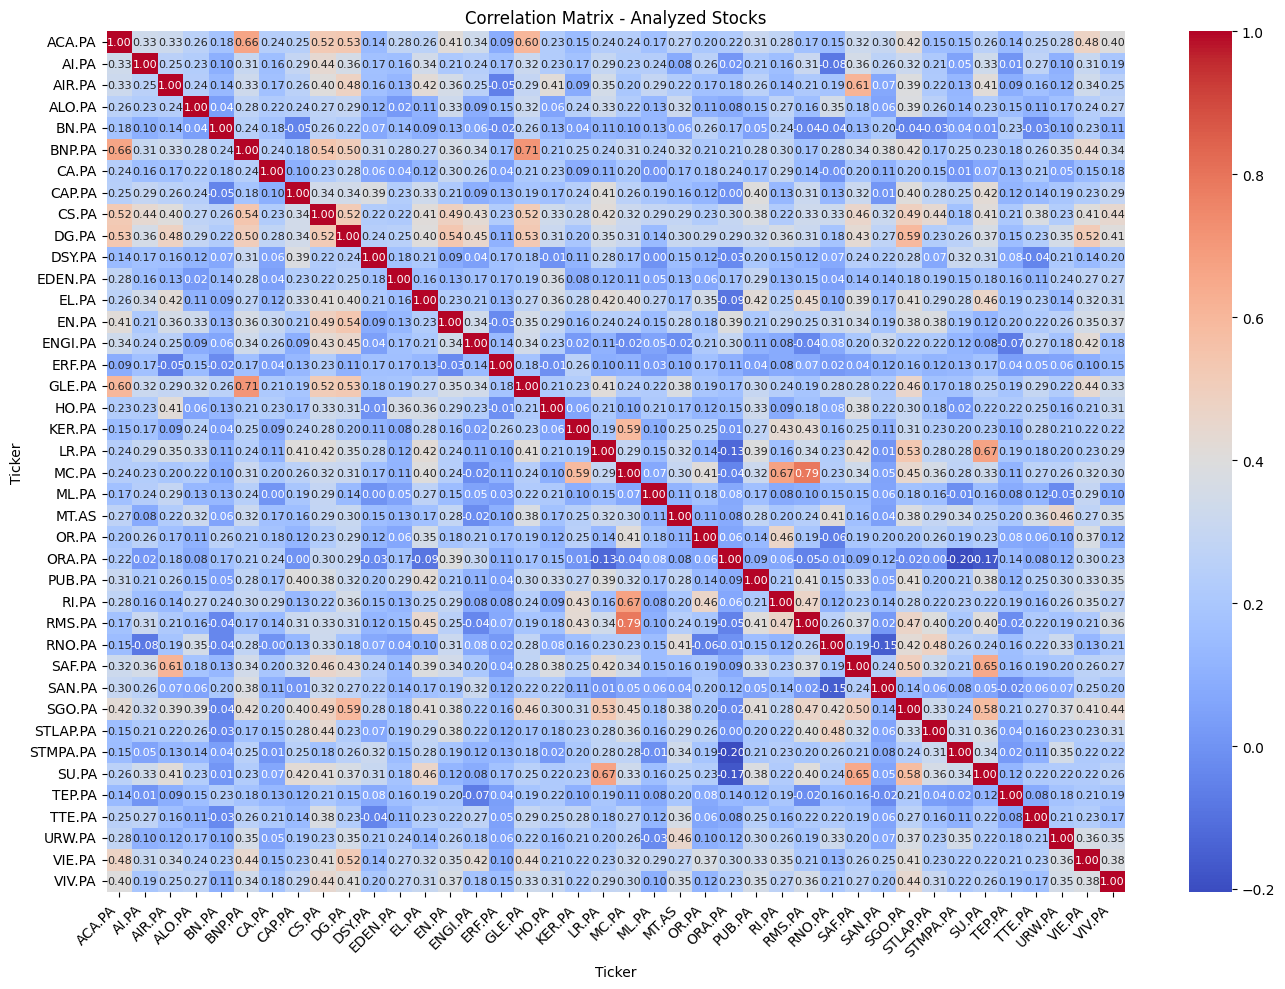

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def Correlation_analysis(tickers, start_date='2024-01-01', end_date=datetime.now().date()):
    # Fetch the stock data
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']

    # Function to compute returns
    def compute_return(prices):
        return prices.pct_change()

    # Compute returns for the stocks
    stock_returns = stock_data.apply(compute_return)

    # Drop NA values
    stock_returns = stock_returns.dropna()

    # Function to compute the covariance matrix
    def compute_covariance_matrix(returns, multiplicator=252):
        return returns.cov() * multiplicator

    # Function to compute the correlation matrix
    def compute_correlation_matrix(returns):
        return returns.corr()

    # Compute and print Covariance Matrix
    cov_matrix = compute_covariance_matrix(stock_returns)
    print("Covariance Matrix:")
    print(cov_matrix)

    # Compute and print Correlation Matrix
    corr_matrix = compute_correlation_matrix(stock_returns)
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Identify the top 5 most correlated pairs
    def get_top_correlated_pairs(corr_matrix, num_pairs=5):
        corr_matrix_unstacked = corr_matrix.unstack()
        sorted_corr_pairs = corr_matrix_unstacked.sort_values(kind="quicksort", ascending=False)
        top_pairs = sorted_corr_pairs[sorted_corr_pairs < 1.0].drop_duplicates().head(num_pairs)
        return top_pairs

    top_correlated_pairs = get_top_correlated_pairs(corr_matrix)
    print("\nTop 5 Most Correlated Pairs:")
    print(top_correlated_pairs)

    # Visualization using Seaborn for the entire period
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix - Analyzed Stocks')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Visualization for different time periods
    # periods = {
    #     "2010-2015": ("2010-01-01", "2014-12-31"),
    #     "2015-2020": ("2015-01-01", "2020-12-31"),
    #     "2020-2023": ("2021-01-01", "2023-12-31")
    # }

    # for period, (start_date, end_date) in periods.items():
    #     temp_returns = stock_data[start_date:end_date].apply(compute_return)
    #     temp_corr_matrix = compute_correlation_matrix(temp_returns.dropna())
    #     plt.figure(figsize=(14, 10))
    #     sns.heatmap(temp_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    #     plt.title(f'Correlation Matrix {period} - Analyzed Stocks')
    #     plt.xticks(rotation=45, ha='right', fontsize=10)
    #     plt.yticks(fontsize=10)
    #     plt.tight_layout()
    #     plt.show()

# Example usage
# Creating a list of CAC 40 tickers for Yahoo Finance in Python

cac40_tickers = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "CS.PA", "BNP.PA", "EN.PA", "CAP.PA",
    "CA.PA", "ACA.PA", "BN.PA", "DSY.PA", "EDEN.PA", "ENGI.PA", "EL.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "LR.PA", "OR.PA", "MC.PA", "ML.PA", "ORA.PA", "RI.PA",
    "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "STLAP.PA",
    "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA", "URW.PA", "VIE.PA", "DG.PA", "VIV.PA"
]

Correlation_analysis(cac40_tickers)


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from datetime import datetime

def fetch_stock_data(tickers, start_date='2024-01-01', end_date=datetime.now().date()):
    return yf.download(tickers, start=start_date, end=end_date)['Close']

def check_cointegration(tickers, start_date='2024-01-01', end_date=datetime.now().date()):
    # Fetch the stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Drop rows with missing values
    stock_data = stock_data.dropna()

    # Initialize a list to store cointegration test results
    coint_results = []

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            stock1 = tickers[i]
            stock2 = tickers[j]

            # Perform the cointegration test
            try:
                score, p_value, crit_value = coint(stock_data[stock1], stock_data[stock2])

                # Append results to the list
                coint_results.append({
                    'Stock1': stock1,
                    'Stock2': stock2,
                    'p-value': p_value,
                    'Test Statistic': score,
                    'Critical Value 1%': crit_value[0],
                    'Critical Value 5%': crit_value[1],
                    'Critical Value 10%': crit_value[2]
                })
            except Exception as e:
                print(f"Error processing {stock1} and {stock2}: {e}")

    # Convert the list to a DataFrame
    coint_results_df = pd.DataFrame(coint_results)

    # Sort results by p-value
    coint_results_df = coint_results_df.sort_values(by='p-value').reset_index(drop=True)

    # Print the top 10 most cointegrated pairs
    print(coint_results_df.head(10))

    return coint_results_df

# Example usage
cac40_tickers = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "CS.PA", "BNP.PA", "EN.PA", "CAP.PA",
    "CA.PA", "ACA.PA", "BN.PA", "DSY.PA", "EDEN.PA", "ENGI.PA", "EL.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "LR.PA", "OR.PA", "MC.PA", "ML.PA", "ORA.PA", "RI.PA",
    "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "STLAP.PA",
    "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA", "URW.PA", "VIE.PA", "DG.PA", "VIV.PA"
]

coint_results = check_cointegration(cac40_tickers)


[*********************100%%**********************]  40 of 40 completed


     Stock1   Stock2   p-value  Test Statistic  Critical Value 1%  \
0     CA.PA   ERF.PA  0.002497       -4.307006          -3.974666   
1     HO.PA   URW.PA  0.002687       -4.286527          -3.974666   
2     BN.PA  EDEN.PA  0.003424       -4.218107          -3.974666   
3     EL.PA    ML.PA  0.006753       -4.018683          -3.974666   
4     CA.PA   ORA.PA  0.010569       -3.879980          -3.974666   
5  STMPA.PA   TTE.PA  0.013002       -3.813570          -3.974666   
6     BN.PA   TEP.PA  0.017156       -3.722190          -3.974666   
7     BN.PA   RNO.PA  0.019000       -3.687758          -3.974666   
8    DSY.PA  EDEN.PA  0.019033       -3.687165          -3.974666   
9     LR.PA    HO.PA  0.019378       -3.681058          -3.974666   

   Critical Value 5%  Critical Value 10%  
0          -3.379192           -3.074242  
1          -3.379192           -3.074242  
2          -3.379192           -3.074242  
3          -3.379192           -3.074242  
4          -3.379192     

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from datetime import datetime

def fetch_stock_data(tickers, start_date='2015-01-01', end_date=datetime.now().date()):
    return yf.download(tickers, start=start_date, end=end_date)['Close']

def test_cointegration(stock1, stock2, start_date='2015-01-01', end_date=datetime.now().date()):
    # Fetch the stock data
    stock_data = fetch_stock_data([stock1, stock2], start_date, end_date)

    # Drop rows with missing values
    stock_data = stock_data.dropna()

    # Perform the cointegration test
    score, p_value, crit_value = coint(stock_data[stock1], stock_data[stock2])

    # Display results
    print(f"Cointegration test between {stock1} and {stock2}")
    print(f"Test Statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical Values: {crit_value}")

    return {
        'Stock1': stock1,
        'Stock2': stock2,
        'p-value': p_value,
        'Test Statistic': score,
        'Critical Value 1%': crit_value[0],
        'Critical Value 5%': crit_value[1],
        'Critical Value 10%': crit_value[2]
    }

# Test cointegration between SAF.PA and AIR.PA
test_cointegration('SAF.PA', 'AIR.PA')


[*********************100%%**********************]  2 of 2 completed


Cointegration test between SAF.PA and AIR.PA
Test Statistic: -0.9589477436954627
p-value: 0.9103605918033804
Critical Values: [-3.90091941 -3.33862709 -3.04618297]


{'Stock1': 'SAF.PA',
 'Stock2': 'AIR.PA',
 'p-value': 0.9103605918033804,
 'Test Statistic': -0.9589477436954627,
 'Critical Value 1%': -3.9009194099958884,
 'Critical Value 5%': -3.3386270944334977,
 'Critical Value 10%': -3.046182970225127}

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def dtw_distance_calculation(ts1, ts2):
    n, m = len(ts1), len(ts2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, :] = np.inf
    dtw_matrix[:, 0] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(ts1[i-1] - ts2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    return dtw_matrix[n, m]

def pair_trading_strategy_dtw(stock_symbols, start_date, end_date, window=20, percentile=95, initial_investment=10000, interval='1d'):
    stock_data = yf.download(stock_symbols, start=start_date, end=end_date, interval=interval)['Close']
    cash = initial_investment
    shares_held = 0
    trades = []
    dtw_distances = []

    for i in range(window, len(stock_data)):
        ts1 = stock_data[stock_symbols[0]][i-window:i]
        ts2 = stock_data[stock_symbols[1]][i-window:i]
        distance = dtw_distance_calculation(ts1, ts2)
        dtw_distances.append(distance)

        if len(dtw_distances) >= window:
            dtw_threshold = np.percentile(dtw_distances[-window:], percentile)

            if distance > dtw_threshold and cash >= stock_data[stock_symbols[0]].iloc[i] * 10 and shares_held == 0:
                shares_held = 10
                cash -= shares_held * stock_data[stock_symbols[0]].iloc[i]
                trades.append(('BUY', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i], shares_held))

            elif distance < dtw_threshold and shares_held > 0:
                cash += shares_held * stock_data[stock_symbols[0]].iloc[i]
                trades.append(('SELL', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i], shares_held))
                shares_held = 0

    final_portfolio_value = cash + shares_held * stock_data[stock_symbols[0]].iloc[-1]
    final_return = (final_portfolio_value - initial_investment) / initial_investment * 100

    return trades, final_return, dtw_distances, stock_data, dtw_threshold

# Define parameters and run the strategy
stock_symbols = ['SAF.PA','AIR.PA']
start_date = '2024-01-01'
end_date = '2024-07-05'
interval = '1d'

trades, final_return, dtw_distances, stock_data, dtw_threshold = pair_trading_strategy_dtw(stock_symbols, start_date, end_date, window=20, percentile=95, initial_investment=10000, interval=interval)

# Plotting
fig = go.Figure()

# Stock Prices
for symbol in stock_symbols:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[symbol], name=symbol))

# DTW Distances
fig.add_trace(go.Scatter(x=stock_data.index[20:], y=dtw_distances, name='DTW Distances', yaxis='y2'))

# Buy/Sell Signals
for trade in trades:
    fig.add_trace(go.Scatter(x=[trade[3]], y=[trade[2]], mode='markers+text', name=f"{trade[0]} Signal", text=[trade[0]], textposition="top center"))

# Layout
fig.update_layout(title="Pair Trading Strategy using DTW",
                  xaxis_title="Date",
                  yaxis_title="Stock Price",
                  yaxis2=dict(title="DTW Distance", overlaying="y", side="right"),
                  legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1),
                  template="plotly_white")

fig.show()

# Print the trades and final return
print("Trading Signals:")
for trade in trades:
    print(f"{trade[0]} {trade[1]} at price {trade[2]} on date {trade[3]} - Number of shares: {trade[4]}")
print(f"Final return from the strategy: {final_return:.2f}%")


[*********************100%%**********************]  2 of 2 completed


Trading Signals:
BUY CA.PA at price 15.430000305175781 on date 2024-03-04 00:00:00 - Number of shares: 10
SELL CA.PA at price 15.694999694824219 on date 2024-03-18 00:00:00 - Number of shares: 10
BUY CA.PA at price 15.954999923706055 on date 2024-04-03 00:00:00 - Number of shares: 10
SELL CA.PA at price 15.890000343322754 on date 2024-04-29 00:00:00 - Number of shares: 10
Final return from the strategy: 0.02%


In [ ]:
import math
import yfinance as yf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def fetch_data(symbol, start_date, end_date, interval):
    return yf.download(symbol, start=start_date, end=end_date, interval=interval)['Close']

def pair_trading_final(ticker1, ticker2, start_date, end_date, interval='1d'):
    dior_data = fetch_data(ticker1, start_date, end_date, interval)
    lvmh_data = fetch_data(ticker2, start_date, end_date, interval)

    aligned_data = pd.concat([dior_data, lvmh_data], axis=1).dropna()
    aligned_data.columns = [ticker1, ticker2]

    X = sm.add_constant(aligned_data[ticker1])
    model = sm.OLS(aligned_data[ticker2], X).fit()
    beta, alpha = model.params[ticker1], model.params['const']

    estimated_lvmh = alpha + beta * aligned_data[ticker1]
    error = aligned_data[ticker2] - estimated_lvmh
    rolling_std = error.rolling(window=20).std()

    trading_records = []  # Initialize a list to keep trading history

    initial_investment = 10000
    cash = initial_investment
    shares_lvmh = 0
    position = 'NONE'

    daily_portfolio_values = pd.DataFrame(index=aligned_data.index, columns=['Portfolio Value'])

    for date, err in error.items():
        price_lvmh = aligned_data.loc[date, ticker2]
        threshold = rolling_std.loc[date]-error.std()  # Dynamic threshold based on rolling standard deviation

        if pd.isna(threshold):
            continue

        if err > threshold and position != 'SHORT':
            if position == 'LONG':
                cash += shares_lvmh * price_lvmh
                shares_lvmh = 0
                trading_records.append({'Date': date, 'Action': 'CLOSE LONG', 'Price': price_lvmh, 'Shares Traded': shares_lvmh, 'Cash After Trade': cash})

            shares_to_trade = math.floor(cash / price_lvmh)
            shares_lvmh -= shares_to_trade
            cash += shares_to_trade * price_lvmh
            position = 'SHORT'
            trading_records.append({'Date': date, 'Action': 'ENTER SHORT', 'Price': price_lvmh, 'Shares Traded': shares_to_trade, 'Cash After Trade': cash})

        elif err < -threshold and position != 'LONG':
            if position == 'SHORT':
                cash += shares_lvmh * price_lvmh
                shares_lvmh = 0
                trading_records.append({'Date': date, 'Action': 'CLOSE SHORT', 'Price': price_lvmh, 'Shares Traded': shares_lvmh, 'Cash After Trade': cash})

            shares_to_trade = math.floor(cash / price_lvmh)
            shares_lvmh += shares_to_trade
            cash -= shares_to_trade * price_lvmh
            position = 'LONG'
            trading_records.append({'Date': date, 'Action': 'ENTER LONG', 'Price': price_lvmh, 'Shares Traded': shares_to_trade, 'Cash After Trade': cash})

        daily_portfolio_values.loc[date, 'Portfolio Value'] = cash + (shares_lvmh * price_lvmh)

    trading_history = pd.DataFrame(trading_records)

    # Final portfolio value
    final_portfolio_value = cash + (shares_lvmh * aligned_data[ticker2].iloc[-1])
    total_return = (final_portfolio_value - initial_investment) / initial_investment * 100

    # Daily Portfolio Value Plotting
    portfolio_fig = go.Figure()
    portfolio_fig.add_trace(go.Scatter(x=daily_portfolio_values.index, y=daily_portfolio_values['Portfolio Value'], mode='lines', name='Daily Portfolio Value', line=dict(color='purple')))
    portfolio_fig.update_layout(title=f'Daily Portfolio Value Tracking', xaxis_title='Date', yaxis_title='Portfolio Value', template='plotly_white')

    # Plotting
    trading_fig = go.Figure()
    trading_fig.add_trace(go.Scatter(x=aligned_data.index, y=aligned_data[ticker1], mode='lines', name=ticker1+" SAFRAN", line=dict(color='green')))
    trading_fig.add_trace(go.Scatter(x=aligned_data.index, y=aligned_data[ticker2], mode='lines', name=ticker2+" AIRBUS", line=dict(color='blue')))
    trading_fig.add_trace(go.Scatter(x=aligned_data.index, y=estimated_lvmh, mode='lines', name='Estimated Value', line=dict(color='orange', dash='dash')))
    for record in trading_records:
        trading_fig.add_trace(go.Scatter(x=[record['Date']], y=[record['Price']], mode='markers', name=record['Action'], marker=dict(size=12, symbol='circle', line=dict(width=2), color='red' if 'SHORT' in record['Action'] else 'green')))
    trading_fig.update_layout(title=f'Trading Strategy with Dynamic Threshold {ticker2}', xaxis_title='Date', yaxis_title='Price', template='plotly_white')

    return total_return, daily_portfolio_values, portfolio_fig, final_portfolio_value, trading_history, trading_fig

# Usage example
total_return, daily_portfolio_values, portfolio_fig, final_portfolio_value, trading_history, trading_fig = pair_trading_final('CA.PA','ERF.PA', '2024-01-01', '2024-07-04', '1d')
print(f"Final Return: {total_return:.2f}%")
print(daily_portfolio_values)
print(trading_history)

portfolio_fig.show()
trading_fig.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Final Return: 76.22%
           Portfolio Value
Date                      
2024-01-02             NaN
2024-01-03             NaN
2024-01-04             NaN
2024-01-05             NaN
2024-01-08             NaN
...                    ...
2024-06-27    18593.464001
2024-06-28    18415.713699
2024-07-01    18178.714302
2024-07-02    17681.013458
2024-07-03    17621.764362

[129 rows x 1 columns]
         Date       Action      Price  Shares Traded  Cash After Trade
0  2024-01-29  ENTER SHORT  56.400002            177      19982.800270
1  2024-01-30  CLOSE SHORT  55.939999              0      10081.420513
2  2024-01-30   ENTER LONG  55.939999            180         12.220760
3  2024-01-31   CLOSE LONG  56.099998              0      10110.220486
4  2024-01-31  ENTER SHORT  56.099998            180      20208.220211
..        ...          ...        ...            ...               ...
86 2024-06-17   ENTER LONG  52.619999            280         17.764996
87 2024-06-18   CLOSE LONG  53.32000

# Moving Averages

## Single Moving Average




In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def fetch_data(symbol, start_date, end_date, interval):
    return yf.download(symbol, start=start_date, end=end_date, interval=interval)['Close']

def moving_average_strategy(ticker, start_date, end_date, interval='1d', initial_capital=10000, T_period=50, ma_type='SMA'):
    # Fetch data
    data = fetch_data(ticker, start_date, end_date, interval)

    # Ensure data is numeric
    data = data.astype(float)

    # Parameters
    T_period = T_period

    # Calculate SMA or EMA
    data = pd.DataFrame(data, columns=['Close'])
    if ma_type == 'SMA':
        data['MA'] = data['Close'].rolling(window=T_period).mean()
    elif ma_type == 'EMA':
        data['MA'] = data['Close'].ewm(span=T_period, adjust=False).mean()
    else:
        raise ValueError("ma_type must be 'SMA' or 'EMA'")

    # Generate Trading Signals
    data['Signal'] = np.where(data['Close'] > data['MA'], 1, -1)

    trading_records = []
    cash = initial_capital
    shares = 0
    position = None

    daily_portfolio_values = pd.DataFrame(index=data.index, columns=['Portfolio Value'])

    for date, row in data.iterrows():
        price = row['Close']
        signal = row['Signal']

        if signal == 1 and position != 'LONG':  # Buy signal
            shares = cash // price
            cash -= shares * price
            position = 'LONG'
            trading_records.append({'Date': date, 'Action': 'BUY', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

        elif signal == -1 and position == 'LONG':  # Sell signal
            cash += shares * price
            shares = 0
            position = 'NONE'
            trading_records.append({'Date': date, 'Action': 'SELL', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

        daily_portfolio_values.loc[date, 'Portfolio Value'] = cash + (shares * price)

    trading_history = pd.DataFrame(trading_records)

    # Final portfolio value
    final_portfolio_value = cash + (shares * data.iloc[-1]['Close'])
    total_return = (final_portfolio_value - initial_capital) / initial_capital * 100

    # Daily Portfolio Value Plotting
    portfolio_fig = go.Figure()
    portfolio_fig.add_trace(go.Scatter(x=daily_portfolio_values.index, y=daily_portfolio_values['Portfolio Value'], mode='lines', name='Daily Portfolio Value', line=dict(color='purple')))
    portfolio_fig.update_layout(title=f'Daily Portfolio Value Tracking ({ma_type})', xaxis_title='Date', yaxis_title='Portfolio Value', template='plotly_white')

    # Trading history and price plot
    trading_fig = go.Figure()
    trading_fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name=f'{ticker} Price', line=dict(color='blue')))
    trading_fig.add_trace(go.Scatter(x=data.index, y=data['MA'], mode='lines', name=f'{T_period}-Day {ma_type}', line=dict(color='green')))
    for record in trading_history.to_dict('records'):
        trading_fig.add_trace(go.Scatter(x=[record['Date']], y=[record['Price']], mode='markers', name=record['Action'], marker=dict(size=12, symbol='circle', line=dict(width=2), color='red' if 'SELL' in record['Action'] else 'green')))
    trading_fig.update_layout(title=f'Trading Strategy with {T_period}-Day {ma_type} for {ticker}', xaxis_title='Date', yaxis_title='Price', template='plotly_white')

    return total_return, daily_portfolio_values, portfolio_fig, final_portfolio_value, trading_history, trading_fig

# Usage example for SMA
total_return_sma, daily_portfolio_values_sma, portfolio_fig_sma, final_portfolio_value_sma, trading_history_sma, trading_fig_sma = moving_average_strategy('AAPL', '2023-01-01', '2024-01-01', '1d', T_period=50, ma_type='SMA')
print(f"SMA Final Return: {total_return_sma:.2f}%")
print(daily_portfolio_values_sma)
print(trading_history_sma)

# Usage example for EMA
total_return_ema, daily_portfolio_values_ema, portfolio_fig_ema, final_portfolio_value_ema, trading_history_ema, trading_fig_ema = moving_average_strategy('AAPL', '2023-01-01', '2024-01-01', '1d', T_period=50, ma_type='EMA')
print(f"EMA Final Return: {total_return_ema:.2f}%")
print(daily_portfolio_values_ema)
print(trading_history_ema)

portfolio_fig_sma.show()
portfolio_fig_ema.show()
trading_fig_sma.show()
trading_fig_ema.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

SMA Final Return: 23.74%
           Portfolio Value
Date                      
2023-01-03         10000.0
2023-01-04         10000.0
2023-01-05         10000.0
2023-01-06         10000.0
2023-01-09         10000.0
...                    ...
2023-12-22    12442.699951
2023-12-26    12407.499756
2023-12-27     12413.89917
2023-12-28    12441.419678
2023-12-29    12374.219482

[250 rows x 1 columns]
        Date Action       Price  Shares Traded  Cash After Trade
0 2023-03-15    BUY  152.990005           65.0         55.649643
1 2023-08-04   SELL  181.990005            0.0      11885.000000
2 2023-08-30    BUY  187.649994           63.0         63.050385
3 2023-09-06   SELL  182.910004            0.0      11586.380615
4 2023-10-11    BUY  179.800003           64.0         79.180420
5 2023-10-17   SELL  177.149994            0.0      11416.780029
6 2023-11-02    BUY  177.570007           64.0         52.299561


EMA Final Return: 47.79%
           Portfolio Value
Date                      
2023-01-03         10000.0
2023-01-04         10000.0
2023-01-05     9894.139687
2023-01-06     9894.139687
2023-01-09     9934.419594
...                    ...
2023-12-22     14860.11013
2023-12-26    14818.309898
2023-12-27    14825.909203
2023-12-28    14858.589806
2023-12-29    14778.789574

[250 rows x 1 columns]
        Date Action       Price  Shares Traded  Cash After Trade
0 2023-01-04    BUY  126.360001           79.0         17.559952
1 2023-01-05   SELL  125.019997            0.0       9894.139687
2 2023-01-06    BUY  129.619995           76.0         43.020058
3 2023-08-04   SELL  181.990005            0.0      13874.260475
4 2023-08-29    BUY  184.119995           75.0         65.260841
5 2023-09-06   SELL  182.910004            0.0      13783.511116
6 2023-10-09    BUY  178.990005           77.0          1.280693
7 2023-10-17   SELL  177.149994            0.0      13641.830223
8 2023-11-02   

## Two Moving Averages

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def fetch_data(symbol, start_date, end_date, interval):
    return yf.download(symbol, start=start_date, end=end_date, interval=interval)['Close']

def moving_average_strategy(ticker, start_date, end_date, interval='1d', initial_capital=10000):
    # Fetch data
    data = fetch_data(ticker, start_date, end_date, interval)

    # Ensure data is numeric
    data = data.astype(float)

    # Parameters
    T_SMA_short = 10
    T_SMA_long = 50
    T_EMA_short = 12
    T_EMA_long = 50

    # Calculate SMAs
    data = pd.DataFrame(data, columns=['Close'])
    data['SMA_short'] = data['Close'].rolling(window=T_SMA_short).mean()
    data['SMA_long'] = data['Close'].rolling(window=T_SMA_long).mean()

    # Calculate EMAs
    data['EMA_short'] = data['Close'].ewm(span=T_EMA_short, adjust=False).mean()
    data['EMA_long'] = data['Close'].ewm(span=T_EMA_long, adjust=False).mean()

    # Generate Trading Signals for SMA
    data['Signal_SMA'] = np.where(data['SMA_short'] > data['SMA_long'], 1, -1)

    # Generate Trading Signals for EMA
    data['Signal_EMA'] = np.where(data['EMA_short'] > data['EMA_long'], 1, -1)

    def backtest(data, signal_column, initial_capital=10000):
        trading_records = []
        cash = initial_capital
        shares = 0
        position = None

        daily_portfolio_values = pd.DataFrame(index=data.index, columns=['Portfolio Value'])

        for date, row in data.iterrows():
            price = row['Close']
            signal = row[signal_column]

            if signal == 1 and position != 'LONG':  # Buy signal
                if position == 'SHORT':
                    cash += shares * price
                    shares = 0
                    trading_records.append({'Date': date, 'Action': 'CLOSE SHORT', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

                shares = cash // price
                cash -= shares * price
                position = 'LONG'
                trading_records.append({'Date': date, 'Action': 'BUY', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

            elif signal == -1 and position == 'LONG':  # Sell signal
                cash += shares * price
                shares = 0
                position = 'NONE'
                trading_records.append({'Date': date, 'Action': 'SELL', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

            daily_portfolio_values.loc[date, 'Portfolio Value'] = cash + (shares * price)

        trading_history = pd.DataFrame(trading_records)

        # Final portfolio value
        final_portfolio_value = cash + (shares * data.iloc[-1]['Close'])
        total_return = (final_portfolio_value - initial_capital) / initial_capital * 100

        return total_return, daily_portfolio_values, final_portfolio_value, trading_history

    # Backtest the SMA strategy
    total_return_sma, daily_portfolio_values_sma, final_portfolio_value_sma, trading_history_sma = backtest(data, 'Signal_SMA', initial_capital)

    # Backtest the EMA strategy
    total_return_ema, daily_portfolio_values_ema, final_portfolio_value_ema, trading_history_ema = backtest(data, 'Signal_EMA', initial_capital)

    # Daily Portfolio Value Plotting for SMA
    portfolio_fig_sma = go.Figure()
    portfolio_fig_sma.add_trace(go.Scatter(x=daily_portfolio_values_sma.index, y=daily_portfolio_values_sma['Portfolio Value'], mode='lines', name='Daily Portfolio Value', line=dict(color='purple')))
    portfolio_fig_sma.update_layout(title=f'Daily Portfolio Value Tracking (SMA)', xaxis_title='Date', yaxis_title='Portfolio Value', template='plotly_white')

    # Daily Portfolio Value Plotting for EMA
    portfolio_fig_ema = go.Figure()
    portfolio_fig_ema.add_trace(go.Scatter(x=daily_portfolio_values_ema.index, y=daily_portfolio_values_ema['Portfolio Value'], mode='lines', name='Daily Portfolio Value', line=dict(color='purple')))
    portfolio_fig_ema.update_layout(title=f'Daily Portfolio Value Tracking (EMA)', xaxis_title='Date', yaxis_title='Portfolio Value', template='plotly_white')

    # Trading history and price plot for SMA
    trading_fig_sma = go.Figure()
    trading_fig_sma.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name=f'{ticker} Price', line=dict(color='blue')))
    trading_fig_sma.add_trace(go.Scatter(x=data.index, y=data['SMA_short'], mode='lines', name='10-Day SMA', line=dict(color='green')))
    trading_fig_sma.add_trace(go.Scatter(x=data.index, y=data['SMA_long'], mode='lines', name='50-Day SMA', line=dict(color='orange', dash='dash')))
    for record in trading_history_sma.to_dict('records'):
        trading_fig_sma.add_trace(go.Scatter(x=[record['Date']], y=[record['Price']], mode='markers', name=record['Action'], marker=dict(size=12, symbol='circle', line=dict(width=2), color='red' if 'SELL' in record['Action'] else 'green')))
    trading_fig_sma.update_layout(title=f'Trading Strategy with SMA for {ticker}', xaxis_title='Date', yaxis_title='Price', template='plotly_white')

    # Trading history and price plot for EMA
    trading_fig_ema = go.Figure()
    trading_fig_ema.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name=f'{ticker} Price', line=dict(color='blue')))
    trading_fig_ema.add_trace(go.Scatter(x=data.index, y=data['EMA_short'], mode='lines', name='12-Day EMA', line=dict(color='green')))
    trading_fig_ema.add_trace(go.Scatter(x=data.index, y=data['EMA_long'], mode='lines', name='50-Day EMA', line=dict(color='orange', dash='dash')))
    for record in trading_history_ema.to_dict('records'):
        trading_fig_ema.add_trace(go.Scatter(x=[record['Date']], y=[record['Price']], mode='markers', name=record['Action'], marker=dict(size=12, symbol='circle', line=dict(width=2), color='red' if 'SELL' in record['Action'] else 'green')))
    trading_fig_ema.update_layout(title=f'Trading Strategy with EMA for {ticker}', xaxis_title='Date', yaxis_title='Price', template='plotly_white')

    return total_return_sma, total_return_ema, daily_portfolio_values_sma, daily_portfolio_values_ema, portfolio_fig_sma, portfolio_fig_ema, final_portfolio_value_sma, final_portfolio_value_ema, trading_history_sma, trading_history_ema, trading_fig_sma, trading_fig_ema

# Usage example
total_return_sma, total_return_ema, daily_portfolio_values_sma, daily_portfolio_values_ema, portfolio_fig_sma, portfolio_fig_ema, final_portfolio_value_sma, final_portfolio_value_ema, trading_history_sma, trading_history_ema, trading_fig_sma, trading_fig_ema = moving_average_strategy('AAPL', '2023-01-01', '2024-01-01', '1d')
print(f"SMA Final Return: {total_return_sma:.2f}%")
print(f"EMA Final Return: {total_return_ema:.2f}%")
print(daily_portfolio_values_sma)
print(trading_history_sma)
print(daily_portfolio_values_ema)
print(trading_history_ema)

portfolio_fig_sma.show()
portfolio_fig_ema.show()
trading_fig_sma.show()
trading_fig_ema.show()


[*********************100%%**********************]  1 of 1 completed


SMA Final Return: 17.22%
EMA Final Return: 38.91%
           Portfolio Value
Date                      
2023-01-03         10000.0
2023-01-04         10000.0
2023-01-05         10000.0
2023-01-06         10000.0
2023-01-09         10000.0
...                    ...
2023-12-22    11785.950851
2023-12-26    11752.950668
2023-12-27    11758.950119
2023-12-28    11784.750595
2023-12-29    11721.750412

[250 rows x 1 columns]
        Date Action       Price  Shares Traded  Cash After Trade
0 2023-03-15    BUY  152.990005           65.0         55.649643
1 2023-08-10   SELL  177.970001            0.0      11623.699722
2 2023-10-17    BUY  177.149994           65.0        108.950119
3 2023-10-23   SELL  173.000000            0.0      11353.950119
4 2023-11-10    BUY  186.399994           60.0        169.950485
           Portfolio Value
Date                      
2023-01-03         10000.0
2023-01-04         10000.0
2023-01-05     9894.139687
2023-01-06    10257.539566
2023-01-09     10299.40

## Three Moving Averages

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def fetch_data(symbol, start_date, end_date, interval):
    return yf.download(symbol, start=start_date, end=end_date, interval=interval)['Close']

def three_moving_average_strategy(ticker, start_date, end_date, interval='1d', initial_capital=10000, T_short=10, T_medium=50, T_long=200, ma_type='SMA'):
    # Fetch data
    data = fetch_data(ticker, start_date, end_date, interval)

    # Ensure data is numeric
    data = data.astype(float)

    # Parameters
    T_short = T_short
    T_medium = T_medium
    T_long = T_long

    # Calculate Moving Averages
    data = pd.DataFrame(data, columns=['Close'])
    if ma_type == 'SMA':
        data['MA_short'] = data['Close'].rolling(window=T_short).mean()
        data['MA_medium'] = data['Close'].rolling(window=T_medium).mean()
        data['MA_long'] = data['Close'].rolling(window=T_long).mean()
    elif ma_type == 'EMA':
        data['MA_short'] = data['Close'].ewm(span=T_short, adjust=False).mean()
        data['MA_medium'] = data['Close'].ewm(span=T_medium, adjust=False).mean()
        data['MA_long'] = data['Close'].ewm(span=T_long, adjust=False).mean()
    else:
        raise ValueError("ma_type must be 'SMA' or 'EMA'")

    # Generate Trading Signals
    data['Signal'] = np.where((data['MA_short'] > data['MA_medium']) & (data['MA_medium'] > data['MA_long']), 1, -1)

    trading_records = []
    cash = initial_capital
    shares = 0
    position = None

    daily_portfolio_values = pd.DataFrame(index=data.index, columns=['Portfolio Value'])

    for date, row in data.iterrows():
        price = row['Close']
        signal = row['Signal']

        if signal == 1 and position != 'LONG':  # Buy signal
            shares = cash // price
            cash -= shares * price
            position = 'LONG'
            trading_records.append({'Date': date, 'Action': 'BUY', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

        elif signal == -1 and position == 'LONG':  # Sell signal
            cash += shares * price
            shares = 0
            position = 'NONE'
            trading_records.append({'Date': date, 'Action': 'SELL', 'Price': price, 'Shares Traded': shares, 'Cash After Trade': cash})

        daily_portfolio_values.loc[date, 'Portfolio Value'] = cash + (shares * price)

    trading_history = pd.DataFrame(trading_records)

    # Final portfolio value
    final_portfolio_value = cash + (shares * data.iloc[-1]['Close'])
    total_return = (final_portfolio_value - initial_capital) / initial_capital * 100

    # Daily Portfolio Value Plotting
    portfolio_fig = go.Figure()
    portfolio_fig.add_trace(go.Scatter(x=daily_portfolio_values.index, y=daily_portfolio_values['Portfolio Value'], mode='lines', name='Daily Portfolio Value', line=dict(color='purple')))
    portfolio_fig.update_layout(title=f'Daily Portfolio Value Tracking ({ma_type})', xaxis_title='Date', yaxis_title='Portfolio Value', template='plotly_white')

    # Trading history and price plot
    trading_fig = go.Figure()
    trading_fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name=f'{ticker} Price', line=dict(color='blue')))
    trading_fig.add_trace(go.Scatter(x=data.index, y=data['MA_short'], mode='lines', name=f'{T_short}-Day {ma_type}', line=dict(color='green')))
    trading_fig.add_trace(go.Scatter(x=data.index, y=data['MA_medium'], mode='lines', name=f'{T_medium}-Day {ma_type}', line=dict(color='orange', dash='dash')))
    trading_fig.add_trace(go.Scatter(x=data.index, y=data['MA_long'], mode='lines', name=f'{T_long}-Day {ma_type}', line=dict(color='red', dash='dot')))
    for record in trading_history.to_dict('records'):
        trading_fig.add_trace(go.Scatter(x=[record['Date']], y=[record['Price']], mode='markers', name=record['Action'], marker=dict(size=12, symbol='circle', line=dict(width=2), color='red' if 'SELL' in record['Action'] else 'green')))
    trading_fig.update_layout(title=f'Trading Strategy with {T_short}/{T_medium}/{T_long}-Day {ma_type} for {ticker}', xaxis_title='Date', yaxis_title='Price', template='plotly_white')

    return total_return, daily_portfolio_values, portfolio_fig, final_portfolio_value, trading_history, trading_fig

# Usage example for SMA
total_return_sma, daily_portfolio_values_sma, portfolio_fig_sma, final_portfolio_value_sma, trading_history_sma, trading_fig_sma = three_moving_average_strategy('AAPL', '2023-01-01', '2024-01-01', '1d', T_short=10, T_medium=50, T_long=200, ma_type='SMA')
print(f"SMA Final Return: {total_return_sma:.2f}%")
print(daily_portfolio_values_sma)
print(trading_history_sma)

portfolio_fig_sma.show()
trading_fig_sma.show()

# Usage example for EMA
total_return_ema, daily_portfolio_values_ema, portfolio_fig_ema, final_portfolio_value_ema, trading_history_ema, trading_fig_ema = three_moving_average_strategy('AAPL', '2023-01-01', '2024-01-01', '1d', T_short=10, T_medium=50, T_long=200, ma_type='EMA')
print(f"EMA Final Return: {total_return_ema:.2f}%")
print(daily_portfolio_values_ema)
print(trading_history_ema)

portfolio_fig_ema.show()
portfolio_fig_sma.show()
trading_fig_sma.show()
trading_fig_ema.show()


[*********************100%%**********************]  1 of 1 completed


SMA Final Return: 1.60%
           Portfolio Value
Date                      
2023-01-03         10000.0
2023-01-04         10000.0
2023-01-05         10000.0
2023-01-06         10000.0
2023-01-09         10000.0
...                    ...
2023-12-22     10215.36084
2023-12-26    10186.760681
2023-12-27    10191.960205
2023-12-28    10214.320618
2023-12-29    10159.720459

[250 rows x 1 columns]
        Date Action       Price  Shares Traded  Cash After Trade
0 2023-10-18    BUY  175.839996           56.0        152.960205
1 2023-10-23   SELL  173.000000            0.0       9840.960205
2 2023-11-10    BUY  186.399994           52.0        148.160522


[*********************100%%**********************]  1 of 1 completed


EMA Final Return: 39.37%
           Portfolio Value
Date                      
2023-01-03         10000.0
2023-01-04         10000.0
2023-01-05     9894.139687
2023-01-06    10257.539566
2023-01-09     10299.40947
...                    ...
2023-12-22    14013.589493
2023-12-26    13973.989273
2023-12-27    13981.188614
2023-12-28    14012.149185
2023-12-29    13936.548965

[250 rows x 1 columns]
        Date Action       Price  Shares Traded  Cash After Trade
0 2023-01-04    BUY  126.360001           79.0         17.559952
1 2023-08-10   SELL  177.970001            0.0      14077.190048
2 2023-09-01    BUY  189.460007           74.0         57.149551
3 2023-09-08   SELL  178.179993            0.0      13242.469009
4 2023-11-08    BUY  182.889999           72.0         74.389053
